# LastFM Recommender Genre Topic Modeling: K Means Clustering + tSNE
July [X], 2018

In [1]:
import sys
sys.executable

'/Users/brianmcmahon/anaconda3/envs/recommender/bin/python'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from os import path, getcwd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from PIL import Image

import gensim
from gensim import matutils, models

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

CWD = '/Volumes/BC_Clutch/Dropbox/recommender_system/'

In [3]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

In [4]:
tag_data = pd.read_csv('../data/recsys_tags2.csv')
tag_data = tag_data.set_index(['idx'])
tag_data['tags'] = tag_data['tags'].apply(lambda x: ', '.join(x.split('|')))
tag_data.head()

,name,tags
idx,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter..."
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt..."
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv..."
3,50 Cent,"00s, american, awesome, catchy, club, dance, g..."
4,A Day to Remember,"<3, acoustic, alternative, american, christian..."


In [5]:
tag_data.tags[0]

'00s, 2008, 90s, acoustic, acoustic rock, alternative, alternative rock, american, awesome, cute, grunge, guilty pleasure, hard rock, love, male vocalists, melancholic, other great tracks, pop, pop rock, post-grunge, prejebeno, punk, rock, romantic, soft rock, soundtrack'

In [6]:
tag_data.shape

(505, 2)

### Assumptions

In [7]:
data = tag_data.tags
n_topics = 6
seed = 42
ngram_range = (1,3)
ncols = 2

sw = set(STOPWORDS)

adds = ['rock','pop','hardcore','vocalist','male','female']
for word in adds:
    sw.add(word)


### K Means Clustering + tSNE

In [8]:
def generate_wordcloud(text): 
    mask=np.array(Image.open(path.join(CWD,'data/guitar_mask.png')))
    
    wc = WordCloud(background_color='white',
                          max_words=2000,
                          mask=mask,
                          random_state=seed,
                          colormap='magma',
                          stopwords=sw)
    wc.generate(text)
       
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    title = "Topic {}".format(i)
    plt.title(title,fontweight='bold',fontsize=16)   


In [9]:
tfidf = TfidfVectorizer(max_df=0.6)
X = tfidf.fit_transform(data)
nmf = NMF(n_components=n_topics, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
X_reduced = nmf.fit_transform(X)

In [10]:
print(tag_data.shape)
print(data.shape)
print(X_reduced.shape)

(505, 2)
(505,)
(505, 6)


KMC saved at ../charts/kmc.png
Inertia score: 3.2557713013456424
Silhouette score: 0.4640277002561153
Cluster 0 has 137 comments.
Cluster 1 has 60 comments.
Cluster 2 has 60 comments.
Cluster 3 has 38 comments.
Cluster 4 has 131 comments.
Cluster 5 has 79 comments.


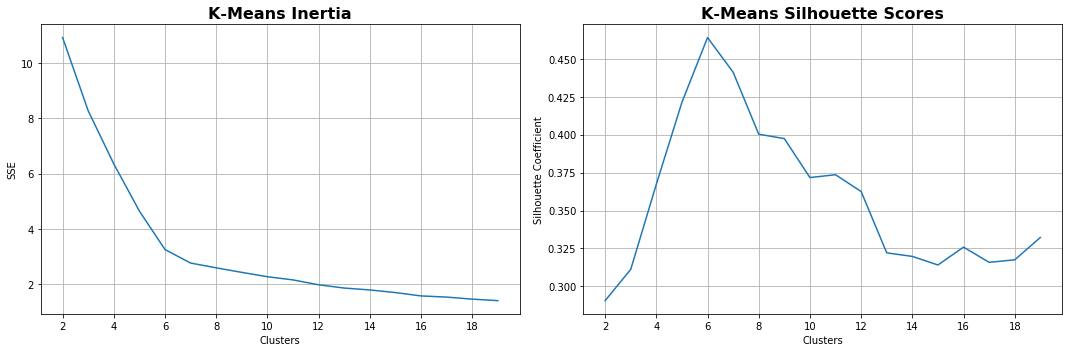

In [11]:
# plot K Means Clusters Silhouette and Clusters Analysis
ns = np.arange(2, 20, 1)
inertias = []
silhouettes = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)
    silhouettes.append(ss)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
# plt.axis([0, 20, 0, 1])
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('K-Means Inertia', fontweight='bold',fontsize=16)
plt.grid()

ax = fig.add_subplot(1,2,2)
# plot the silhouette scores
plt.plot(ns, silhouettes)
# plt.axis([0, 20, 0, 1])
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel('Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('K-Means Silhouette Scores', fontweight='bold',fontsize=16)
plt.grid()

plt.tight_layout()
filepath1 = "../charts/kmc.png"
plt.savefig(filepath1)
print("KMC saved at " + filepath1)
# Fit Kmeans with n_clusters
kmeans = KMeans(n_clusters=n_topics, init="k-means++", random_state=seed)
kmf = kmeans.fit(X_reduced)
labels = kmf.labels_
ssc = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)

print("Inertia score: {}".format(kmf.inertia_))
print("Silhouette score: {}".format(ssc))
for cluster in range(len(set(labels))):
    print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster)))

WordClouds saved at ../charts/wc_kmctsne.png


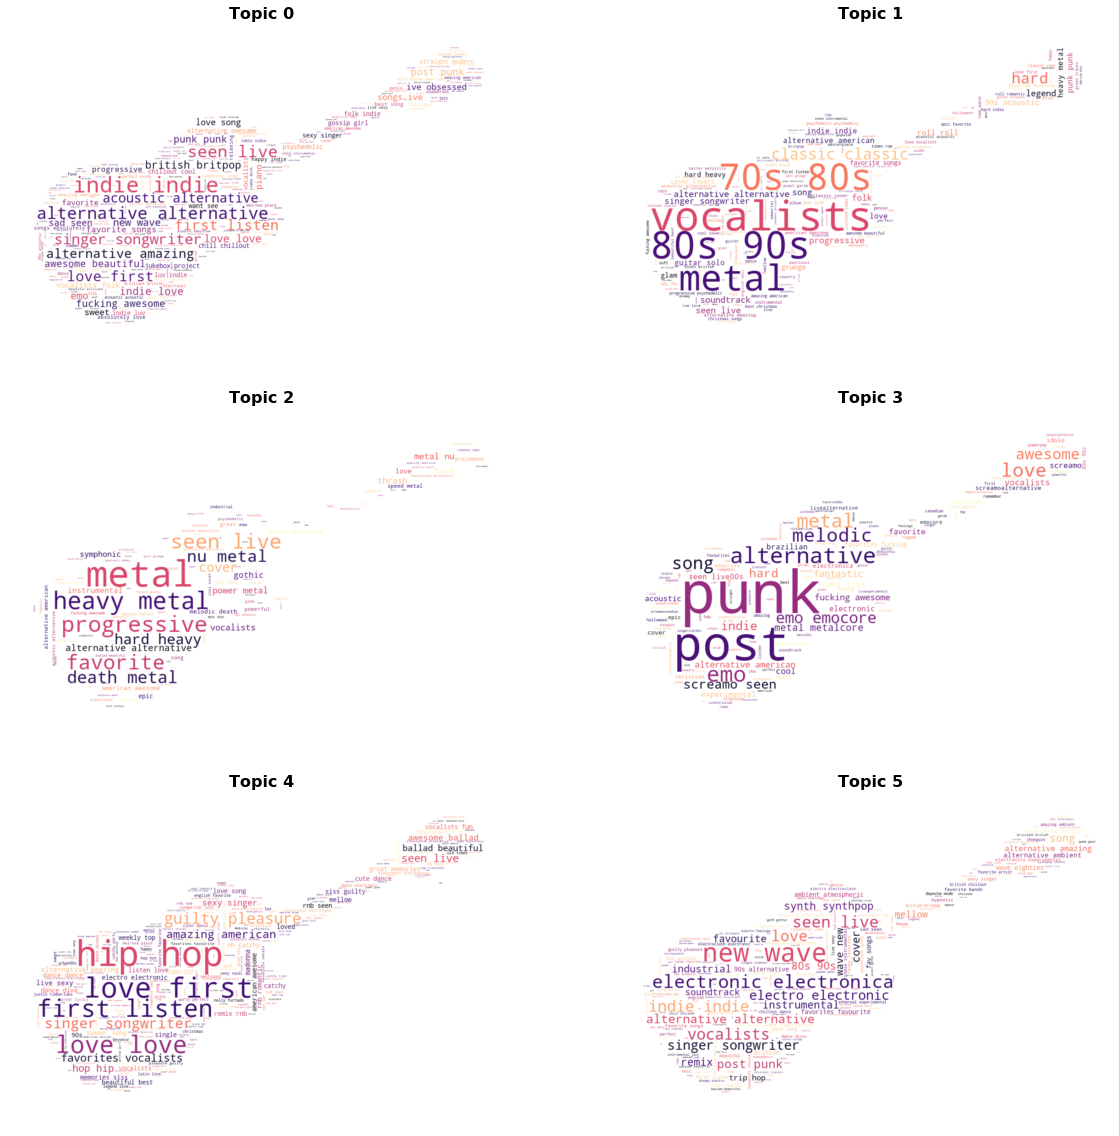

In [12]:
cluster_map = pd.DataFrame(X_reduced)
cluster_map['comments'] = [r for r in data]
cluster_map['cluster'] = labels

fig = plt.figure(figsize=(20,20))
# ncols = 2
nrows = math.ceil(n_topics / ncols)
# plt.tight_layout()

for i in range(n_topics):
    ax = fig.add_subplot(nrows,ncols,i+1)
    text = ''.join(cluster_map[cluster_map.cluster==i].comments)
    
    generate_wordcloud(text)   
    
filepath3 = "../charts/wc_kmctsne.png"
print("WordClouds saved at " + filepath3)
plt.savefig(filepath3)

T-SNE saved at ../charts/tsne.png


<Figure size 720x720 with 0 Axes>

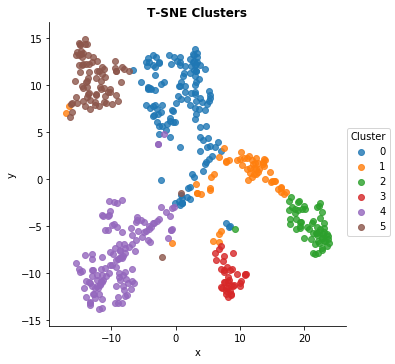

In [13]:
tsne = TSNE(n_components=2, init='pca',perplexity=40, n_iter=500, random_state=seed)
tsne = tsne.fit_transform(X_reduced)
df_tsne = pd.DataFrame(tsne, columns=["tsne_x", "tsne_y"])
df_tsne["Cluster"] = labels
df_tsne["Cluster"] = df_tsne["Cluster"].apply(str)
df_tsne["Artist"] = [a for a in tag_data.name]

fig = plt.figure(figsize=(10,10))
tsne = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")

plt.xlabel("x")
plt.ylabel("y")
plt.title("T-SNE Clusters",fontweight='bold')
filepath2 = "../charts/tsne.png"
plt.savefig(filepath2)
print("T-SNE saved at " + filepath2)

In [14]:
# list artists by cluster
df_tsne[['Cluster','Artist']].sort_values('Cluster')

,Cluster,Artist
252,0,Kings of Convenience
109,0,Colbie Caillat
110,0,Coldplay
308,0,Modest Mouse
302,0,Mika
300,0,Michel Teló
115,0,Damien Rice
298,0,Metric
295,0,McFly
119,0,Dashboard Confessional


In [15]:
assert len(data)==len(df_tsne)

In [16]:
df_tsne.head()

,tsne_x,tsne_y,Cluster,Artist
0,5.562,0.232,1,3 Doors Down
1,7.873,-4.664,0,30 Seconds to Mars
2,-10.947,-5.476,4,3OH!3
3,-6.762,-6.869,4,50 Cent
4,8.190,-11.553,3,A Day to Remember


In [17]:
df_tsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
tsne_x     505 non-null float32
tsne_y     505 non-null float32
Cluster    505 non-null object
Artist     505 non-null object
dtypes: float32(2), object(2)
memory usage: 11.9+ KB


In [78]:
df_tsne['meta'] = df_tsne[['Artist','Cluster']].apply(lambda x: '-'.join(x), axis=1)

In [79]:
df_tsne.head()

,tsne_x,tsne_y,Cluster,Artist,meta
0,5.562,0.232,1,3 Doors Down,3 Doors Down-1
1,7.873,-4.664,0,30 Seconds to Mars,30 Seconds to Mars-0
2,-10.947,-5.476,4,3OH!3,3OH!3-4
3,-6.762,-6.869,4,50 Cent,50 Cent-4
4,8.190,-11.553,3,A Day to Remember,A Day to Remember-3


In [80]:
# Formatted for Google Embedding Projector
# https://projector.tensorflow.org/
vectors = pd.DataFrame(X_reduced)
meta = pd.DataFrame(df_tsne['meta'])
print(vectors.shape, meta.shape)
meta.to_csv('../data/meta.tsv',sep='\t',index=False,header=False)
vectors.to_csv('../data/vectors.tsv',sep='\t',index=False,header=False)

(505, 6) (505, 1)


In [21]:
vectors.head()

,0,1,2,3,4,5
0,0.051,0.003,0.024,0.023,0.115,0.000
1,0.100,0.059,0.046,0.113,0.037,0.020
2,0.029,0.030,0.167,0.000,0.000,0.052
3,0.000,0.000,0.141,0.000,0.000,0.000
4,0.010,0.002,0.000,0.295,0.009,0.000


In [22]:
df_tsne['Cluster'].shape

(505,)

In [23]:
data.head()

idx
0    00s, 2008, 90s, acoustic, acoustic rock, alter...
1    00s, <3, acoustic, addictive, alternative, alt...
2    00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...
3    00s, american, awesome, catchy, club, dance, g...
4    <3, acoustic, alternative, american, christian...
Name: tags, dtype: object